<a href="https://colab.research.google.com/github/pachterlab/CP_2023/blob/main/notebooks/umapTransformAnalysis/merfish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import os


from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#Pseudotime Packer & Zhu C. elegans data
#counts.mtx
download_file('10.22002/D1.2060','.gz')

#cells.csv
download_file('10.22002/D1.2061','.gz')

#genes.csv
download_file('10.22002/D1.2062','.gz')


#MERFISH data

#metadata.csv
download_file('10.22002/D1.2063','.gz')

#counts.h5ad
download_file('10.22002/D1.2064','.gz')

os.system("gunzip *.gz")

os.system("mv D1.2063 metadata.csv")
os.system("mv D1.2064 counts.h5ad")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/14905 [00:00<?, ?B/s]

  0%|          | 0/561 [00:00<?, ?B/s]

  0%|          | 0/165 [00:00<?, ?B/s]

  0%|          | 0/9784 [00:00<?, ?B/s]

  0%|          | 0/59360 [00:00<?, ?B/s]

0

In [ ]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 145 (delta 78), reused 95 (delta 38), pack-reused 0
Receiving objects: 100% (145/145), 412.94 KiB | 4.69 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
%cd /content/densvis/densne/

/content/densvis/densne


In [ ]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [ ]:
%cd /content/

/content


In [ ]:
!git clone https://github.com/pachterlab/CP_2023.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 205 (delta 93), reused 77 (delta 17), pack-reused 0
Receiving objects: 100% (205/205), 65.03 MiB | 19.43 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [ ]:
%cd /content/CP_2023/scripts

/content/CP_2022/scripts


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy

     |████████████████████████████████| 91 kB 3.0 MB/s 
     |████████████████████████████████| 7.7 MB 4.7 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
     |████████████████████████████████| 1.1 MB 39.7 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


## **Install Packages**

In [ ]:
import statistics
import anndata
import pandas as pd
import numpy as np
from Picasso import Picasso
import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis,NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib

from sklearn.metrics import accuracy_score

matplotlib.rc('axes',edgecolor='black')
%matplotlib inline

sc.set_figure_params(dpi=125)
sns.set_style('white')

## **Import Data**

In [ ]:
# General parameters
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '/content'

n_latent = 50
pcs = 50

## **Merfish Data**

In [ ]:
counts = anndata.read(data_path+'/counts.h5ad')
print(counts)

cellMeta = pd.read_csv(data_path+'/metadata.csv')
print(cellMeta.head())

AnnData object with n_obs × n_vars = 280327 × 254
     Unnamed: 0  fovID     fov_x  ...     label     subclass    class_label
0  1.000010e+37     13  4539.310  ...   Astro_1   Astrocytes          Other
1  1.000020e+38    290 -4016.860  ...      Endo  Endothelial          Other
2  1.000070e+38    113   750.406  ...       SMC          SMC          Other
3  1.000070e+38    432  1262.680  ...      Endo  Endothelial          Other
4  1.000090e+38    354 -3627.450  ...  L23_IT_3       L23_IT  Glutamatergic

[5 rows x 12 columns]


In [ ]:
axisFontSize = 11
tickFontSize = 10
errwidth=1
figsize =(8,4)
dodge=0.4

In [ ]:
cellMeta.columns

Index(['Unnamed: 0', 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x',
       'center_y', 'slice_id', 'sample_id', 'label', 'subclass',
       'class_label'],
      dtype='object')

In [ ]:
choice = np.unique(cellMeta.slice_id)[7] #7
choice

'mouse1_slice162'

In [ ]:
counts.obs['slice'] = pd.Categorical(cellMeta.slice_id)
counts.obs['type'] = pd.Categorical(cellMeta.subclass)
counts.obs['x'] = list(cellMeta.center_x)
counts.obs['y'] = list(cellMeta.center_y)


In [ ]:
sub = counts[counts.obs['slice'].isin([choice])]
print(sub)

#colors = np.random.rand(len(sub.obs['type']),3)
nanLabs = np.array([[np.nan]*len(sub.obs['type'])])

labs = np.array([list(sub.obs['type'])])
labs_cont = np.array([list(sub.obs['x']),list(sub.obs['y'])])

View of AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'slice', 'type', 'x', 'y'


In [ ]:
#colors = np.random.rand(len(adata2.obs['Cluster']),3)
cdict = {'Microglia':'#A778BC','L6_IT':'#EA95C1','Astrocytes':'#B6657E','Oligodendrocytes':'#B49599',
         'L23_IT':'#628EA2','OPC':'#72B9A5','L45_IT':'#71B7A2','Endothelial':'#7794C3','Pvalb':'#FD8085',
         'L6_IT_Car3':'#FAD1FC','L56_NP':'#93B09B','PVM':'#ECBDD2','L5_IT':'#ABA8DF',
         'L5_PT':'#D36486','Sst':'#8FE0B1','L6_CT':'#9589C4','Vip':'#CD83AC','VLMC':'#BBDBF2',
         'SMC':'#7A849E','other':'#A382BC','L6b':'#64D7F0','Pericytes':'#95BA98',
         'Lamp5':'#A3E169','Sncg':'#92B1DB','Sst_Chodl':'#81FAC9'}
colors = [cdict[i] for i in pd.unique(sub.obs['type'])]

In [ ]:
sub.obs['type'].value_counts()

L45_IT              977
L23_IT              946
L6_CT               582
Astrocytes          546
Oligodendrocytes    522
Endothelial         505
L5_IT               441
L6_IT               439
other               204
Pericytes           195
L5_PT               185
Microglia           182
Pvalb               167
PVM                 164
VLMC                139
OPC                 131
L6_IT_Car3          123
SMC                 119
L6b                 104
Sst                  92
L56_NP               78
Lamp5                59
Vip                  53
Sncg                  5
Sst_Chodl             5
Name: type, dtype: int64

Make log-normalized, and scaled count matrices (separately)

In [ ]:
orig_mat = sub.X

In [ ]:
log_mat = np.log1p(sub.X)

In [ ]:
sc.pp.log1p(sub)

#Center scale
sc.pp.scale(sub, max_value=10)

scaled_mat = sub.X

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:339: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
amb = tl.getCentroidDists(log_mat,labs[0])
ambIntra = tl.getIntraVar(log_mat, labs[0],labs[0])

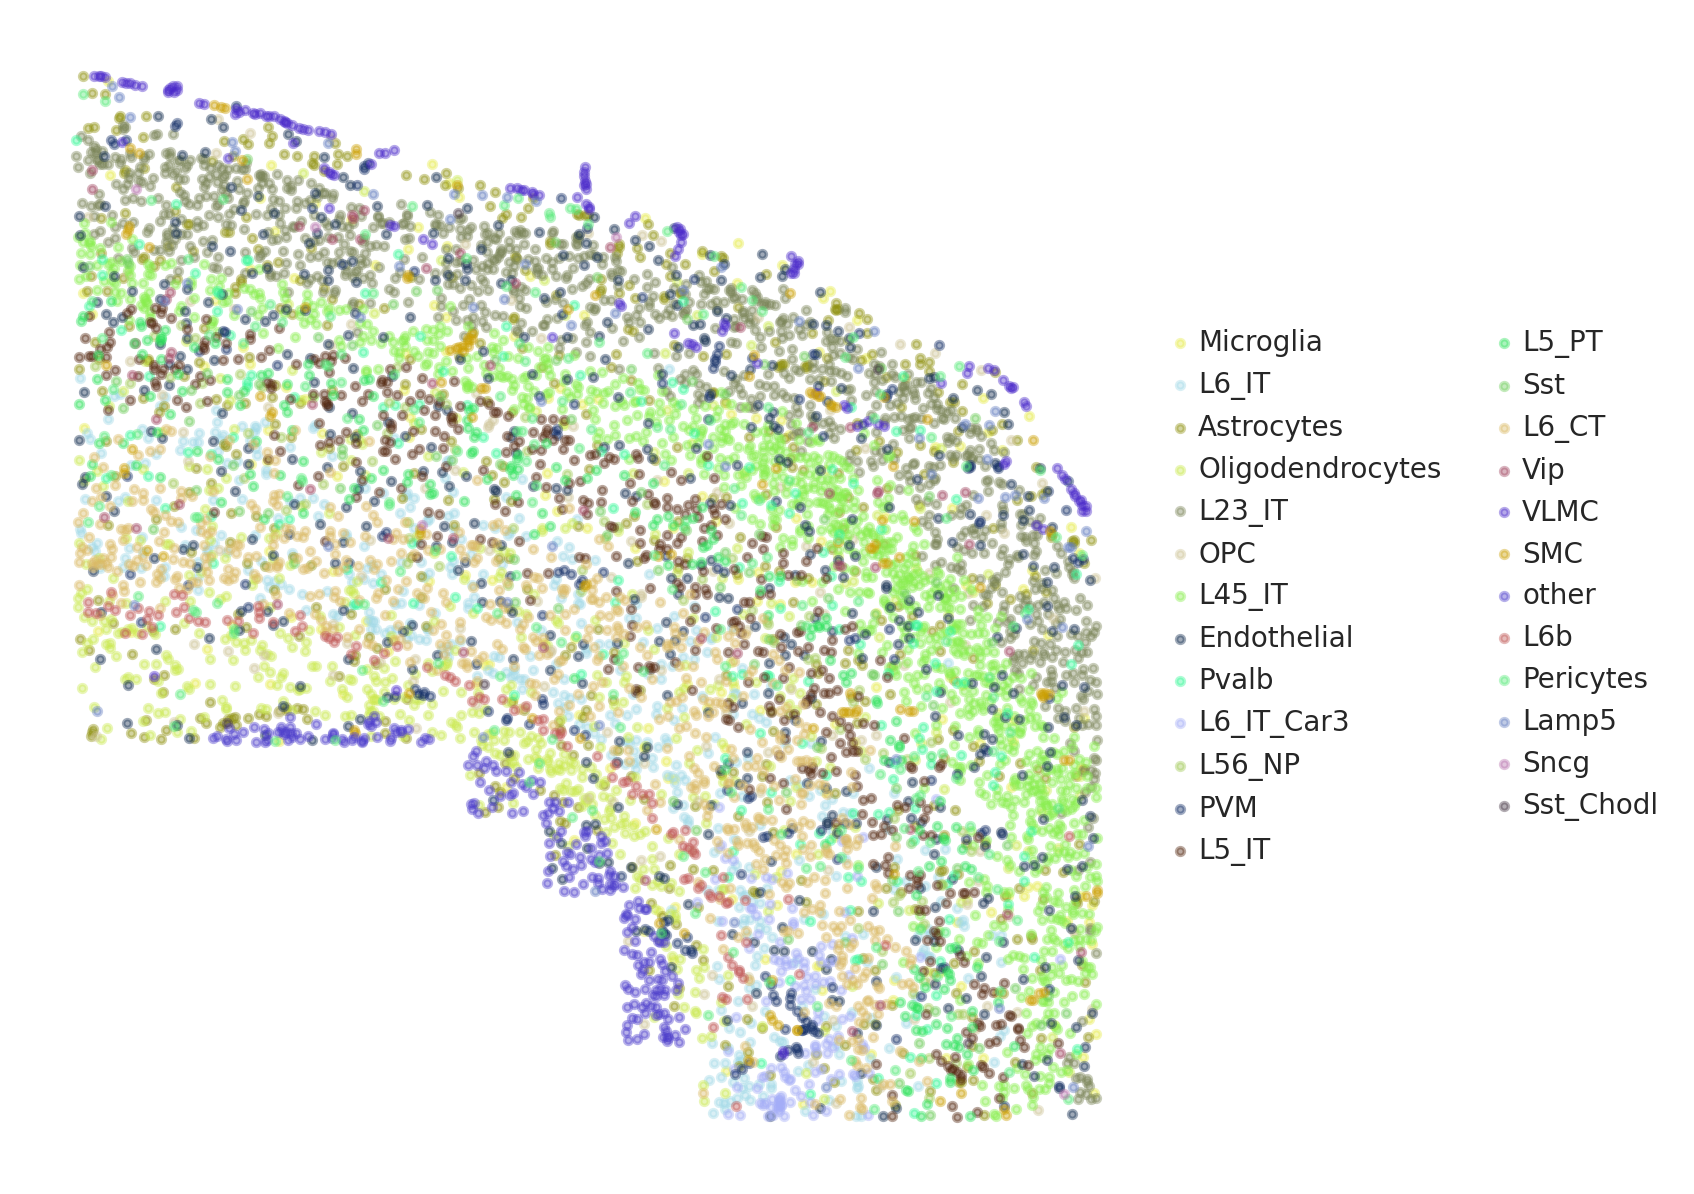

In [ ]:
vis.obj_plot_embed(labs_cont.T, labs[0], fname = '2DNCA.pdf', colors=colors )

### **PCA/UMAP Test**

Check to see how embedding imposes false structure when applied to new data.

In [ ]:
#PCA
pcs2 = 15
tsvd = TruncatedSVD(n_components=pcs2)
x_pca = tsvd.fit_transform(scaled_mat)

# tsvd = TruncatedSVD(n_components=2)
# x_pca_2d = tsvd.fit_transform(scaled_mat)

reducer = umap.UMAP(n_components = 2)
pcaUMAP = reducer.fit_transform(x_pca)
# pcaDensUMAP = densUMAP.fit_transform(x_pca)

# pcaTSNE = tsne.fit_transform(x_pca)
# pcaDensTSNE, ro ,re = densne.run_densne(x_pca,no_dims = ndims, randseed = state)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


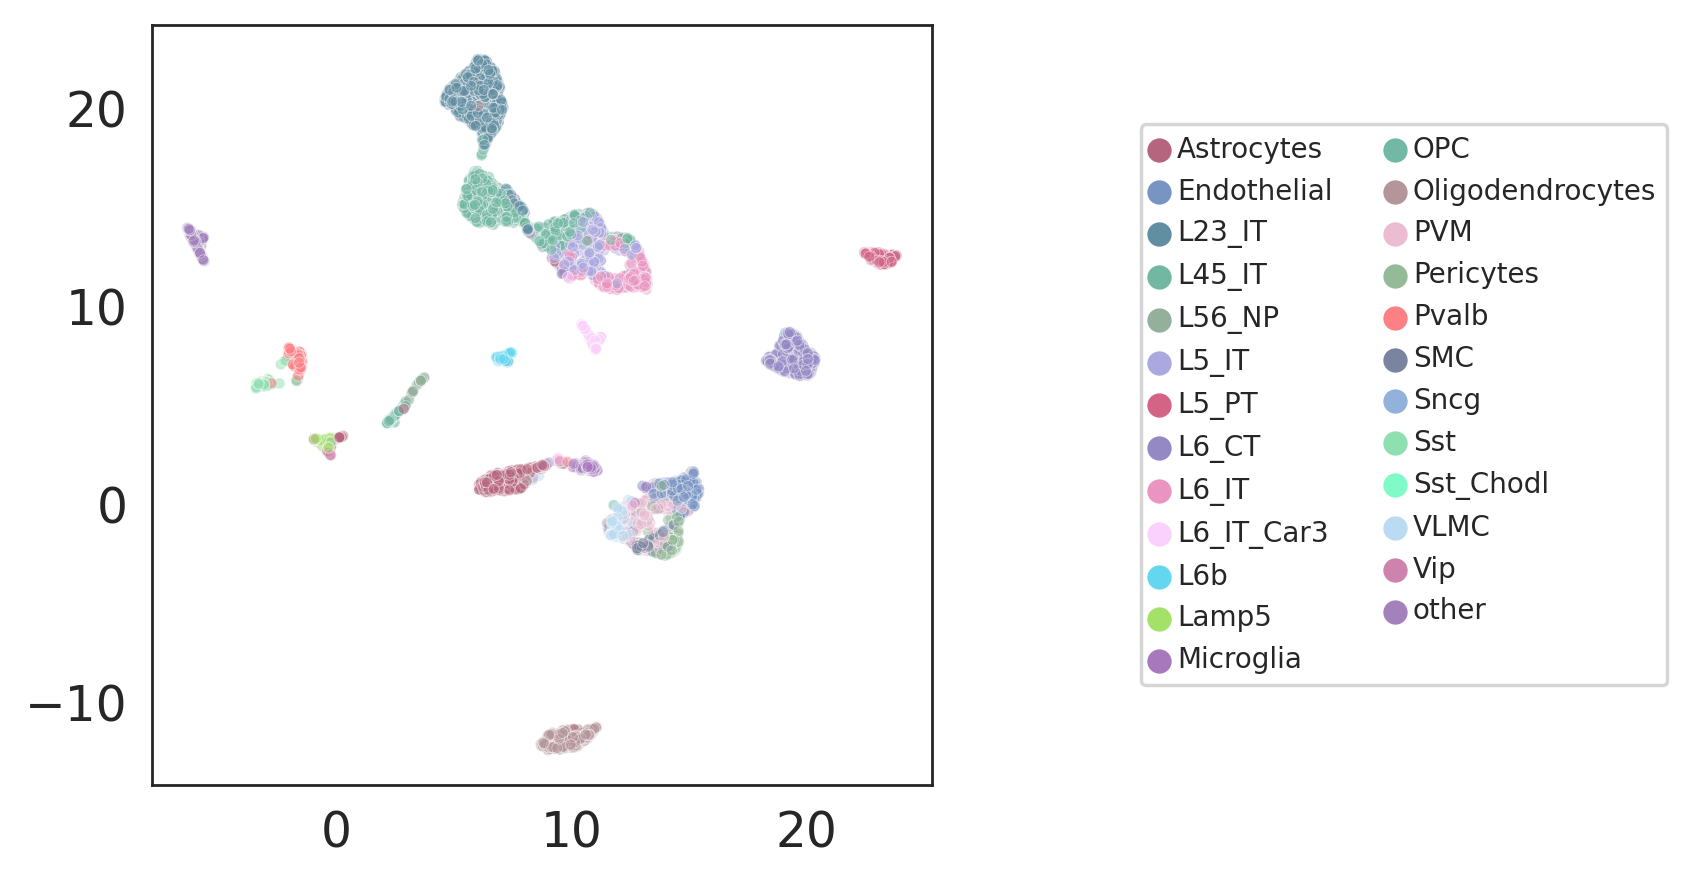

In [ ]:
#Data UMAP

g=sns.scatterplot(pcaUMAP[:,0],pcaUMAP[:,1],hue=pd.Categorical(labs[0]),palette = cdict, alpha=0.5,s=10)
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=2, fontsize=8)
plt.grid(False)

In [ ]:
# Generate "num_points" random points in "dimension" that have uniform
# probability over the unit ball scaled by "radius" (length of points
# are in range [0, "radius"]).
def random_ball(num_points, dimension, radius=1):
    from numpy import random, linalg
    # First generate random directions by normalizing the length of a
    # vector of random-normal values (these distribute evenly on ball).
    random_directions = random.normal(size=(dimension,num_points))
    random_directions /= linalg.norm(random_directions, axis=0)
    # Second generate a random radius with probability proportional to
    # the surface area of a ball with a given radius.
    random_radii = random.random(num_points) ** (1/dimension)
    # Return the list of random (direction & length) points.
    return radius * (random_directions * random_radii).T

In [ ]:
rand_coords = random_ball(5000, pcs2, radius=1)

In [ ]:
reducer.fit(x_pca) #Fit to biological data
coord_trans = reducer.transform(rand_coords) #Transform uniform coordinates

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


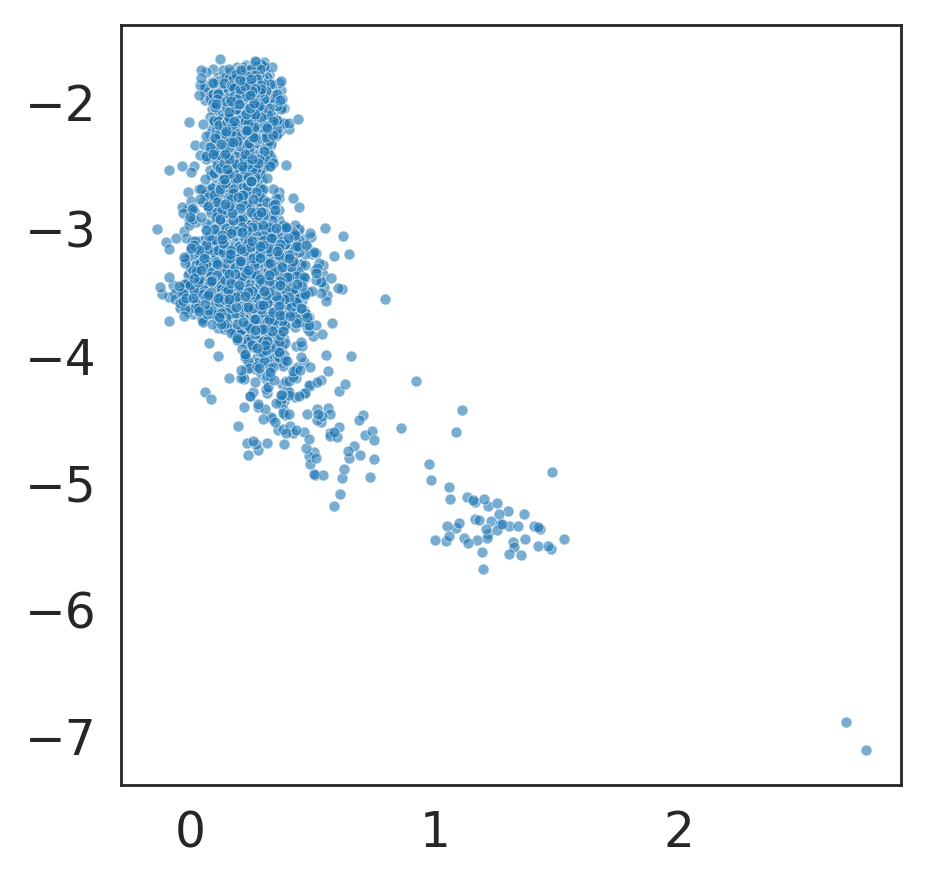

In [ ]:
sns.scatterplot(coord_trans[:,0],coord_trans[:,1],s=10,alpha=0.6)

In [ ]:

coord_trans2 = reducer.fit_transform(rand_coords)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


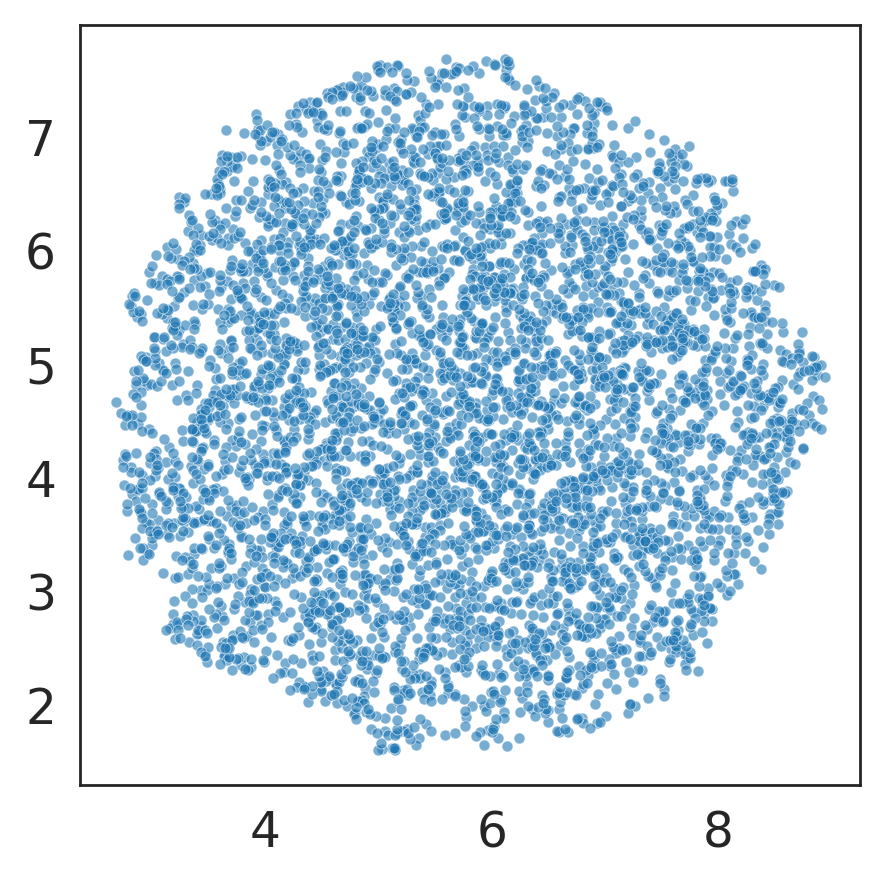

In [ ]:
sns.scatterplot(coord_trans2[:,0],coord_trans2[:,1],s=10,alpha=0.6)